## Convolutional Neural Network 



In this notebook you will learn to distinguish dogs from cats!

Data:
https://drive.google.com/drive/folders/1nzVk4GOvKR6P87uPszUkKMPtaXV_wrZf?usp=sharing

Fill all the necessary gaps in cells below and fit neural networks for solving the binary classification task.

## Task 1:

1. Build and fit CNN with 3 convolutional layers for binary classification
2. Evaluate accuracy on test data
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)

First, let's load all the necessary functions:


In [1]:
import argparse
from collections import defaultdict
import os
import os.path as osp

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision.models import vgg16, resnet18
from torchvision.transforms import transforms
import tqdm

from albumentations import (
    Blur,
    CoarseDropout,
    Compose,
    GaussNoise,
    HorizontalFlip,
    OneOf,
    RandomRotate90,
    RandomSizedCrop,
    Rotate,
    ShiftScaleRotate,
    VerticalFlip,
)

from utils.config import config

The images collected for training and testing the deep learning model must be prepared: split the entire set into a training, validation and test sample, observing the balancing of classes (with binary classification they should be approximately equal in all three samples).

This has _already_ been done: in the Cats_and_Dogs directory there are three subdirectories: train, test and val - training, test and validation samples, respectively.

**UPD**

The code will be implemented using PyTorch.

Data was saved to local storage at `'../data/task4'`.

### Define train-wise parameters and constants

In [2]:
args = argparse.Namespace(
    network="my",
    size=224,
    augmentation_intensity="heavy",
    batch_size=64,
    num_workers=6,
    test_mode=False,
    test_size=64,
    num_epochs=20,
    lr=0.005,
    weight_decay=0.0001
)

transform_clf = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### Dataset and dataloaders

## Prepare the data.

You don’t have to manually change the shapes of 25000 images and convert them into the necessary format for keras (img_width, img_height, 3).

We will use the built-in image preprocessing function _ImageGenerator()_.

It performs scaling, resizes selected images and prepares batches (mini-samples) to train the model.

In [3]:
def get_augmentations(resize=224, augmentation_intensity=None, gauss_limit=0.05):
    crop_limits = (int(resize * 0.85), resize)

    if augmentation_intensity == "light":
        p_augment = 0.25
        p_scale = 0.2
        p_blur = 0.1
        p_dropout = 0.05
        p_flip = 0.2
        p_noise = 0.2
    elif augmentation_intensity == "medium":
        p_augment = 0.5
        p_scale = 0.2
        p_blur = 0.2
        p_dropout = 0.1
        p_flip = 0.2
        p_noise = 0.2
    elif augmentation_intensity == "heavy":
        p_augment = 0.5
        p_scale = 0.35
        p_blur = 0.35
        p_dropout = 0.15
        p_flip = 0.35
        p_noise = 0.35
    elif augmentation_intensity is None:
        return None
    else:
        raise ValueError("Improper augmentation flag: should be equal to None, light, medium, or heavraisey")

    augmentation = Compose(
        [
            OneOf([HorizontalFlip(), VerticalFlip()], p=p_flip,),
            OneOf([Rotate(p=1.0, limit=30), RandomRotate90(p=1.0)], p=p_scale,),
            OneOf(
                [
                    ShiftScaleRotate(p=1.0, rotate_limit=30),
                    RandomSizedCrop(
                        min_max_height=crop_limits,
                        height=resize,
                        width=resize,
                        w2h_ratio=1.0,
                        interpolation=cv2.INTER_CUBIC,
                    ),
                ],
                p=p_scale,
            ),
            Blur(blur_limit=3, p=p_blur),
            CoarseDropout(max_height=7, max_width=7, p=p_dropout),
            GaussNoise(var_limit=(0.0, gauss_limit), p=p_noise),
        ],
        p=p_augment,
    )

    return augmentation


class MyDataset(Dataset):
    def __init__(self, data_dir, size, test_mode=False, test_size=64, augment=None, transform=None):
        # Cats have target 0, dogs have target 1
        self.make_markup(data_dir, test_mode, test_size)
        self.size = size
        self.augment = augment
        self.transform = transform
        
    def make_markup(self, data_dir, test_mode=False, test_size=64):
        markup = []
        for root, _, files in os.walk(data_dir):
            for fname in sorted(files):
                target = root.endswith("dogs")
                fpath = osp.join(root, fname)
                markup.append({"fpath": fpath, "target": target})
        markup = pd.DataFrame(markup)
        if test_mode:
            markup = markup.groupby("target").head(test_size).reset_index(drop=True)
        self.markup = markup
    
    def __len__(self):
        return self.markup.shape[0]
    
    def __getitem__(self, idx):
        row = self.markup.iloc[idx]
        img = cv2.imread(row["fpath"])[:,:,::-1]
        img = cv2.resize(img, (self.size, self.size))
        
        if self.augment:
            img = self.augment(image=img)["image"]
            
        if self.transform:
            img = self.transform(img)
            
        target = int(row["target"])
        
        return img, target
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


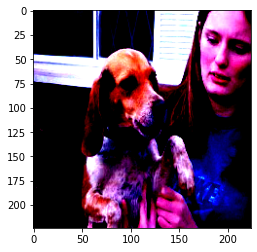

In [4]:
# Demonstrate that dataset is working

data_dir = osp.join(config.data_dir, "task4", "train")
train_ds = MyDataset(data_dir, size=224, transform=transform_clf)

idx = 500
img, target = train_ds[idx]
plt.imshow(np.moveaxis(img.numpy(), (0, 1, 2), (2, 0, 1)));

In [5]:
def create_dataloaders(args):
    dataloaders = {}
    for split in ["train", "val", "test"]:
        data_dir = osp.join(config.data_dir, "task4", split)
        if split == "train":
            augment = get_augmentations(resize=args.size, augmentation_intensity=args.augmentation_intensity, gauss_limit=0.05)
            shuffle = True
        else:
            augment = None
            shuffle = False
        
        ds = MyDataset(data_dir, size=args.size, test_mode=args.test_mode, test_size=args.test_size, augment=augment, transform=transform_clf)
        dataloaders[split] = DataLoader(ds, shuffle=shuffle, batch_size=args.batch_size, num_workers=args.num_workers)
    return dataloaders

In [6]:
loaders = create_dataloaders(args)

for split, loader in loaders.items():
    print(f"Split {split}, number of batches: {len(loader)}, number of samples in dataset: {len(loader.dataset)}")

Split train, number of batches: 313, number of samples in dataset: 20000
Split val, number of batches: 39, number of samples in dataset: 2490
Split test, number of batches: 40, number of samples in dataset: 2500


### Network, optimizer, and sheduler

Set the network architecture by sequentially adding layers to it:
1. A convolutional layer with 16 neurons, filter size 3x3. Activation function - 'relu'
2. MaxPooling layer with filter size 2x2.
3. A convolutional layer with 32 neurons, filter size 3x3. Activation function - 'relu'
4. MaxPooling layer with filter size 2x2.
5. A convolutional layer with 64 neurons, filter size 3x3. Activation function - 'relu'
6. MaxPooling layer with filter size 2x2.
7. Operation model.add (Flatten ()), which makes a one-dimensional vector of the resulting feature maps.
8. A fully connected layer with 64 neurons. Activation function - 'relu'
9. Use model.add (Dropout (0.5)) which excludes the edge from the current layer in the computational graph with a 50% probability to avoid overfitting.
10. A fully connected layer with 1 neuron. Activation function - 'sigmoid', because binary classification model.

Add to the model all the missing layers, by analogy with the already specified.
Keras documentation: https://keras.io/layers/about-keras-layers/

In [7]:
class MyModel(nn.Module):
    def __init__(self, in_channels=3, channels=(16, 32, 64)):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels, channels[0], (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(channels[0], channels[1], (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(channels[1], channels[2], (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.AdaptiveMaxPool2d((16, 16)),
            nn.Flatten(),
            nn.Dropout(p=0.5)
        )
        fc_input = 16 * 16 * 64
        self.classifier = nn.Linear(fc_input, 1)
        
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    

def create_model(args):
    if args.network == "my":
        model = MyModel()
    elif args.network == "vgg16":
        model = vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 1),
        )
    elif args.network == "resnet18":
        model = resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Sequential(
            nn.Linear(512, 1),
        )
    else:
        raise NotImplementedError(f"Invalid value of args.network, got {args.network}")
    return model

In [8]:
@torch.no_grad()
def eval_net(model, loader):
    model.eval()
    data = defaultdict(list)
    for batch in tqdm.tqdm(loader, total=len(loader), desc="Eval"):
        scores = torch.sigmoid(model(batch[0].to(config.device))).cpu()[: ,0]
        data["gt"].extend(batch[1].numpy())
        data["probas"].extend(scores.numpy())
        data["preds"].extend((scores.numpy() > 0.5).astype(int))
    data = pd.DataFrame(data)
    auc = metrics.roc_auc_score(data["gt"], data["probas"])
    acc = metrics.accuracy_score(data["gt"], data["preds"])
    return auc, acc
    
def train_net(model, loaders, optimizer, criterion, num_epochs=10):
    train_metrics = []
    best_state = None
    best_auc = 0
    best_epoch = 0
    for epoch in range(num_epochs):
        running_loss = 0
        model.train()
        for batch in tqdm.tqdm(loaders["train"], total=len(loaders["train"]), desc=f"Train epoch {epoch}"):
            optimizer.zero_grad()
            output = model(batch[0].to(config.device))[:, 0]
            target = batch[1].float().to(config.device)
            loss = criterion(output, target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        mean_loss = running_loss / len(loaders["train"])
        val_auc, val_acc = eval_net(model, loaders["val"])
        train_auc, train_acc = eval_net(model, loaders["train"])
        
        if val_auc > best_auc:
            best_auc = val_auc
            best_epoch = epoch
            best_state = model.state_dict()
        
        train_metrics.append({
            "epoch": epoch,
            "loss": mean_loss,
            "train_auc": train_auc,
            "train_acc": train_acc,
            "val_auc": val_auc,
            "val_acc": val_acc
        })
        print(f"Epoch {epoch}, loss {loss:.4f}, train_auc {train_auc:.4f}, train_acc {train_acc:.4f}, val_auc {val_auc:.4f}, val_acc {val_acc:.4f}")
    return pd.DataFrame(train_metrics), best_state, best_epoch
            

def train_model(args):
    loaders = create_dataloaders(args)
    model = create_model(args)
    model.train()
    model.to(config.device)
    optimizer = Adam([p for p in model.parameters() if p.requires_grad], lr=args.lr, weight_decay=args.weight_decay)
    criterion = nn.BCEWithLogitsLoss()
    
    train_metrics, best_state, best_epoch = train_net(model, loaders, optimizer, criterion, num_epochs=args.num_epochs)
    model.load_state_dict(best_state)
    test_auc, test_acc = eval_net(model, loaders["test"])
    return train_metrics, test_auc, test_acc, best_epoch, model

### Training

In [21]:
args = argparse.Namespace(
    network="my",
    size=224,
    augmentation_intensity=None,
    batch_size=64,
    num_workers=6,
    test_mode=False,
    test_size=128,
    num_epochs=20,
    lr=0.0005,
    weight_decay=0.0001
)

In [22]:
train_metrics, test_auc, test_acc, best_epoch, model = train_model(args)

Train epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0, loss 0.5040, train_auc 0.8536, train_acc 0.7722, val_auc 0.8498, val_acc 0.7614


Train epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1, loss 0.4137, train_auc 0.8857, train_acc 0.8021, val_auc 0.8745, val_acc 0.7791


Train epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2, loss 0.2393, train_auc 0.9028, train_acc 0.8200, val_auc 0.8880, val_acc 0.7980


Train epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3, loss 0.3954, train_auc 0.9099, train_acc 0.8236, val_auc 0.8917, val_acc 0.8052


Train epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4, loss 0.4842, train_auc 0.9232, train_acc 0.8459, val_auc 0.9014, val_acc 0.8209


Train epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5, loss 0.3155, train_auc 0.9296, train_acc 0.8393, val_auc 0.9078, val_acc 0.8201


Train epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6, loss 0.2312, train_auc 0.9339, train_acc 0.8555, val_auc 0.9086, val_acc 0.8309


Train epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7, loss 0.2969, train_auc 0.9383, train_acc 0.8627, val_auc 0.9090, val_acc 0.8321


Train epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8, loss 0.3266, train_auc 0.9436, train_acc 0.8330, val_auc 0.9118, val_acc 0.8036


Train epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9, loss 0.3139, train_auc 0.9471, train_acc 0.8582, val_auc 0.9138, val_acc 0.8237


Train epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10, loss 0.2399, train_auc 0.9515, train_acc 0.8779, val_auc 0.9170, val_acc 0.8378


Train epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11, loss 0.5520, train_auc 0.9516, train_acc 0.8804, val_auc 0.9131, val_acc 0.8353


Train epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12, loss 0.2121, train_auc 0.9553, train_acc 0.8764, val_auc 0.9200, val_acc 0.8365


Train epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13, loss 0.3542, train_auc 0.9574, train_acc 0.8822, val_auc 0.9217, val_acc 0.8434


Train epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14, loss 0.3628, train_auc 0.9609, train_acc 0.8890, val_auc 0.9233, val_acc 0.8418


Train epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15, loss 0.3741, train_auc 0.9610, train_acc 0.8873, val_auc 0.9198, val_acc 0.8373


Train epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16, loss 0.3252, train_auc 0.9661, train_acc 0.8992, val_auc 0.9243, val_acc 0.8522


Train epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17, loss 0.2903, train_auc 0.9673, train_acc 0.9023, val_auc 0.9239, val_acc 0.8510


Train epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18, loss 0.3839, train_auc 0.9668, train_acc 0.8995, val_auc 0.9234, val_acc 0.8446


Eval:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19, loss 0.2244, train_auc 0.9697, train_acc 0.9033, val_auc 0.9262, val_acc 0.8498


Eval: 100%|██████████| 40/40 [00:03<00:00, 12.11it/s]


In [24]:
os.makedirs(config.log_dir, exist_ok=True)
train_metrics.to_csv(osp.join(config.log_dir, "my.csv"), index=False)
os.makedirs(config.model_dir, exist_ok=True)
torch.save(model.state_dict(), osp.join(config.model_dir, "my.pth"))

### Plot metrics

Plot the graphs: 

- Loss(Number of epochs)

- Accuracy(Number of epochs)

In [64]:
def plot_metrics(train_metrics, best_epoch, test_auc, test_acc):
    plt.figure(figsize=(8, 6))

    for metric, color in zip(
        ["loss", "train_auc", "train_acc", "val_auc", "val_acc"],
        ["blue", "violet", "brown", "red", "green"]
    ):
        plt.plot(train_metrics["epoch"], train_metrics[metric], label=metric, color=color)
        if "auc" in metric:
            plt.scatter(train_metrics["epoch"], train_metrics[metric], label=metric, color=color)
            
    plt.scatter(best_epoch, test_auc, label="test_auc", color="yellow")
    plt.scatter(best_epoch, test_acc, label="test_acc", color="darkorange")
    plt.xlim([0.0, train_metrics["epoch"].max() + 0.5])
    plt.ylim([0.0, 1.05])

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Metric value", fontsize=16)
    plt.title("Metrics", fontsize=20)
    plt.legend(fontsize=16)
    plt.legend()
    plt.show()

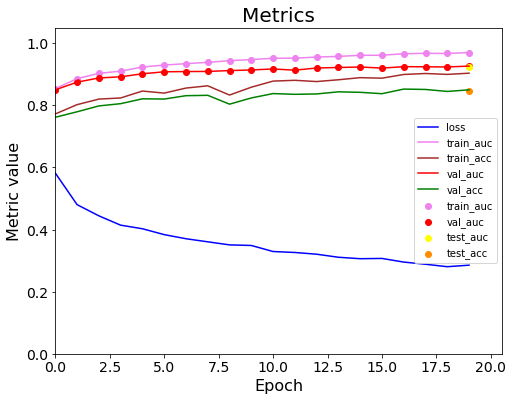

In [27]:
plot_metrics(train_metrics, best_epoch, test_auc, test_acc)

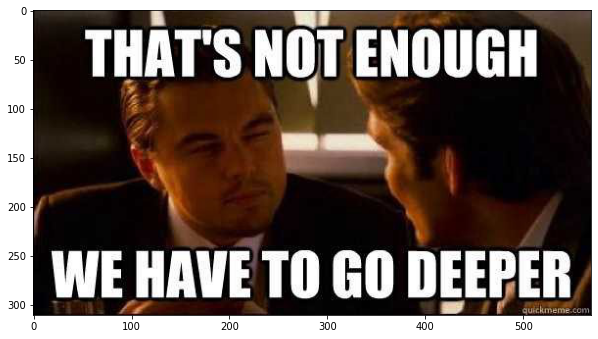

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread('/content/drive/My Drive/Deeper.jpeg')
plt.figure(figsize = (10,20))
plt.imshow(img)
plt.show()


Let's try to improve the quality of recognition, using the method of transfer lerning. 

We will use weights of deep neural networks already trained on large dataset such as  ImageNet, and provide fine tuning of several additional dense layers on new data relevant to the current classification task. The more new images will differ from those on which the network has been trained, the more layers will need to be “retrained” in order to get good classification accuracy. The intuition here is that the model has already learned how to highlight the necessary features on the images in the large dataset, it only needs to be “tweaked” for a specific task.

## Task 2

1. Build and fit Transfer Learning model using pre-trained VGG16-model weights from keras application.
2. Do the same with **another avaliable pre-trained deep learning model** from keras application https://keras.io/api/applications/.
2. Evaluate accuracy on test data for p.1 and p.2
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)
4. Check the performance of your model with the custom image of cat or dog (so the model will tell which class this image belongs to). Develop the function for the inference of the best algorithm.

### VGG

E.g., it was like:


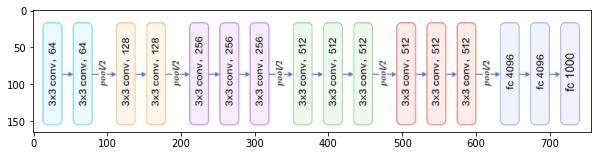

In [ ]:
img = mpimg.imread('/content/drive/My Drive/VGG16.png')
plt.figure(figsize = (10,20))
plt.imshow(img)
plt.show()

and it becomes:

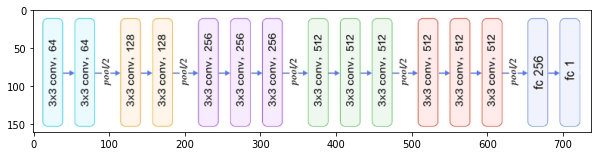

In [ ]:
img = mpimg.imread('/content/drive/My Drive/VGG162.png')
plt.figure(figsize = (10,20))
plt.imshow(img)
plt.show()

**UPD**

See implementation of layers freezing and head redefinement in the function `create_model`.

In [57]:
args = argparse.Namespace(
    network="vgg16",
    size=224,
    augmentation_intensity="light",
    batch_size=64,
    num_workers=6,
    test_mode=False,
    test_size=128,
    num_epochs=5,
    lr=0.00001,
    weight_decay=0.0001
)

In [58]:
train_metrics, test_auc, test_acc, best_epoch, model = train_model(args)

Train epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0, loss 0.0165, train_auc 0.9990, train_acc 0.9851, val_auc 0.9988, val_acc 0.9867


Train epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1, loss 0.0274, train_auc 0.9994, train_acc 0.9889, val_auc 0.9989, val_acc 0.9896


Train epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2, loss 0.0786, train_auc 0.9996, train_acc 0.9907, val_auc 0.9989, val_acc 0.9900


Train epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3, loss 0.0192, train_auc 0.9997, train_acc 0.9929, val_auc 0.9990, val_acc 0.9900


Eval:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4, loss 0.0286, train_auc 0.9998, train_acc 0.9950, val_auc 0.9990, val_acc 0.9904


Eval: 100%|██████████| 40/40 [00:24<00:00,  1.65it/s]


In [59]:
train_metrics.to_csv(osp.join(config.log_dir, "vgg16.csv"), index=False)
torch.save(model.state_dict(), osp.join(config.model_dir, "vgg16.pth"))

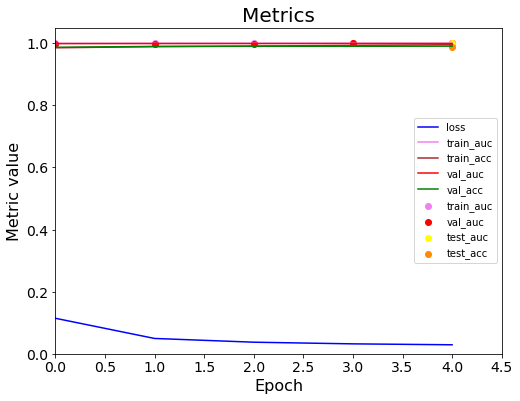

In [65]:
plot_metrics(train_metrics, best_epoch, test_auc, test_acc)

### ResNet-18

In [66]:
args = argparse.Namespace(
    network="resnet18",
    size=224,
    augmentation_intensity=None,
    batch_size=64,
    num_workers=6,
    test_mode=False,
    test_size=128,
    num_epochs=5,
    lr=0.0001,
    weight_decay=0.0001
)

In [67]:
train_metrics, test_auc, test_acc, best_epoch, model = train_model(args)

Train epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0, loss 0.3116, train_auc 0.9884, train_acc 0.9431, val_auc 0.9878, val_acc 0.9474


Train epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1, loss 0.2500, train_auc 0.9943, train_acc 0.9600, val_auc 0.9944, val_acc 0.9647


Train epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2, loss 0.2591, train_auc 0.9958, train_acc 0.9666, val_auc 0.9961, val_acc 0.9731


Train epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3, loss 0.1348, train_auc 0.9964, train_acc 0.9688, val_auc 0.9967, val_acc 0.9751


Eval:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4, loss 0.1516, train_auc 0.9968, train_acc 0.9713, val_auc 0.9971, val_acc 0.9767


Eval: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


In [68]:
train_metrics.to_csv(osp.join(config.log_dir, "resnet18.csv"), index=False)
torch.save(model.state_dict(), osp.join(config.model_dir, "resnet18.pth"))

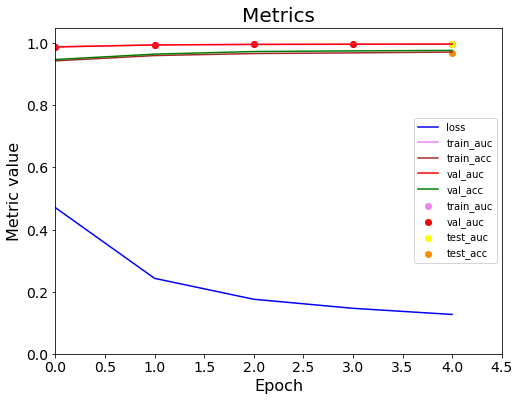

In [69]:
plot_metrics(train_metrics, best_epoch, test_auc, test_acc)

## Inference

It's my cat, but at the moment she wasn't in the mood, and I didn't capture her face. Let's see if the network thinks that it is cat.

![my_cat](../../imgs/my_cat.png)

In [79]:
args = argparse.Namespace(
    network="vgg16",
    size=224,
)

In [80]:
@torch.no_grad()
def predict(model, img_path):
    img = cv2.imread(img_path)[:,:,::-1]
    plt.imshow(img)
    img = cv2.resize(img, (args.size, args.size))
    img = transform_clf(img)
    
    output = torch.sigmoid(model(img.unsqueeze(0).to(config.device))).cpu()[0, 0]
    plt.title(f"It's a dog with probability {output:.4f}")
    plt.show()

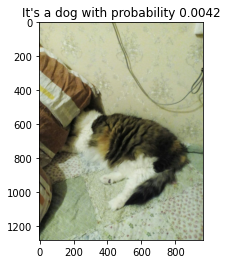

In [81]:
model = create_model(args)
model.load_state_dict(torch.load(osp.join(config.model_dir, f"{args.network}.pth")))
model.eval()
model.to(config.device)

predict(model, osp.join("../../imgs/my_cat.png"))

VGG16 considers this cutiepie definitely not a dog. Good)